Author of notebook: Luis A Haddock Soto (TCF Lab)

Date Created: 2023-04-03

Date last modified: 2023-05-31

## Tracing the origin of SARS-CoV-2 Omicron-like Spike sequences detected in wastewater

Martin M Shafer%,  Max J Bobholz%,  William C Vuyk%,  Devon A Gregory%,  Adelaide Roguet,  Luis A Haddock Soto, Clayton Rushford,  Kayley H Janssen,  Hunter J Ries,  Hannah E Pilch,  Paige A Mullen,  Rebecca B Fahney,  Wanting Wei, Matthew Lambert, Jeff Wenzel,  Peter Halfmann,  Yoshihiro Kawaoka,  Nancy A Wilson,  Thomas C Friedrich,  Ian W Pray,  Ryan Westergaard,  David H O'Connor, Marc Johnson^

%equal contribution

[View preprint](https://www.medrxiv.org/content/10.1101/2022.10.28.22281553v4)


^Corresponding Author  
Marc C. Johnson  
Phone: 573-882-1519  
marcjohnson@missouri.edu  
471c Bond Life Sciences Center  
1201 Rollins St  
Columbia, MO USA 65211



These sequence reads were generated by the Wisconsin State Laboratory of Hygiene using an Illumina MiSeq instrument  from 425 amplicons covering the whole SARS-CoV-2 genome amplified from wastewater samples with the QIAseq DIRECT SARS-CoV-2 Kit A. 

Illumina_WGS fastq files contain these unaligned sequence reads. Each sample should have both an R1 and and R2 fastq file, which result from Illumina's paired-end sequencing technique. Illumina reads are highly accurate and short.




### SARS-CoV-2 Annotations

https://www.ncbi.nlm.nih.gov/gene/43740568

### SARS-CoV-2 Reference used

MN908947 - Available on NCBI under GENBANK ID [MN908947.3](https://www.ncbi.nlm.nih.gov/nuccore/MN908947)

In [8]:
# Importing different modules (we might not use all of them)
import pandas as pd
import numpy as np
from brokenaxes import brokenaxes
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import datetime as dt
import matplotlib as mpl
from pandas.plotting import table
import seaborn as sns
from scipy import stats
from statistics import mean
from scipy.integrate import quad
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import csv
import plotly.express as px
import scipy.stats as sp
import plotly.io as pio
from plotly.subplots import *
from pathlib import Path
import numpy as np
import json
import requests
import datetime
from Bio import SeqIO
%load_ext rpy2.ipython
from varcode import Variant
from pyensembl import ensembl_grch37
from sklearn.linear_model import LinearRegression

# installation should be pip install git+https://github.com/jsh9/python-plot-utils  
# instead of pip install git+https://github.com/jsh9/python-plot-utilities

import imp
# utils = imp.load_source('utils', 'utils.py')
# utils_plotting = imp.load_source('utils_plotting', 'utils_plotting.py')
# from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_del_accumulation_attr
# from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
#from augur.utils import json_to_tree
import matplotlib.gridspec as gridspec
from os import listdir
from os.path import isfile, join
import requests
import json
import math
import string
from os import path
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo


In [27]:
#cleaning up the metadata

df = pd.read_csv('ncbi/sequences.csv')
df[['state','county']] = df['Geo_Location'].str.split(',',expand=True)

df['location'] = df['state'].str[5:]

df['location'] = df['location'].replace({'IA':'Iowa', 'IL':'Illinois','IN':'Indiana', 
                                         'KS':'Kansas', 'MI':'Missouri', 'MN':'Minnesota',
                                        'MO':'Missouri', 'NE':'Nebraska', 'OH':'Ohio'})

df.rename(columns={'Accession': 'strain', 'Collection_Date': 'date','location': 'division'}, inplace=True)

df.to_csv('divergence_analysis/b1234_sars_metadata_raw.tsv', sep='\t')

In [2]:
df = pd.read_csv('ncbi/sequences.csv')
n_by_state = df.groupby("Collection_Date")["Accession"].count()
n_by_state.head(60)

df['count'] =1
df['Collection_Date'] = pd.to_datetime(df['Collection_Date']) - pd.to_timedelta(7, unit='d')
groups = df.groupby([pd.Grouper(key='Collection_Date', freq='M')])['count'].sum()



In [28]:
# adding a column with WHO assignments for all lineages

df = pd.read_csv('divergence_analysis/b1234_sars_metadata_raw.tsv', sep='\t')

df.loc[df['Pangolin'] == "B.1.1.7", 'WHO_class'] = 'Alpha'
df.loc[df['Pangolin'] == "B.1.351", 'WHO_class'] = 'Beta'
df.loc[df['Pangolin'] == "P.1", 'WHO_class'] = 'Gamma'
df.loc[df['Pangolin'] == "B.1.617.2", 'WHO_class'] = 'Delta'
df.loc[df['Pangolin'].str.startswith('AY'), 'WHO_class'] = 'Delta'
df.loc[df['Pangolin'].str.startswith('B.1.42'), 'WHO_class'] = 'Epsilon'
df.loc[df['Pangolin'] == "B.1.525", 'WHO_class'] = 'Eta'
df.loc[df['Pangolin'] == "B.1.526", 'WHO_class'] = 'Iota'
df.loc[df['Pangolin'] == "B.617.1", 'WHO_class'] = 'Kappa'
df.loc[df['Pangolin'].str.startswith('B.1.621'), 'WHO_class'] = 'Mu'
df.loc[df['Pangolin'] == "P.2", 'WHO_class'] = 'Zeta'
df.loc[df['Pangolin'] == "B.1.1.529", 'WHO_class'] = 'Omicron'
df.loc[df['Pangolin'].str.startswith('B.1.234'), 'WHO_class'] = 'B.1.234'
df.loc[df['Pangolin'].str.startswith('BA.1'), 'WHO_class'] = 'Omicron BA.1'
df.loc[df['Pangolin'].str.startswith('BA.2'), 'WHO_class'] = 'Omicron BA.2'
df.loc[df['Pangolin'].str.startswith('BA.3'), 'WHO_class'] = 'Omicron BA.3'
df.loc[df['Pangolin'].str.startswith('BA.4'), 'WHO_class'] = 'Omicron BA.4'
df.loc[df['Pangolin'].str.startswith('BA.5'), 'WHO_class'] = 'Omicron BA.5'
df.loc[df['Pangolin'].str.startswith('BA.6'), 'WHO_class'] = 'Omicron BA.6'
df.loc[df['Pangolin'].str.startswith('BF'), 'WHO_class'] = 'Omicron (other)'
df.loc[df['Pangolin'].str.startswith('BE'), 'WHO_class'] = 'Omicron (other)'
df.loc[df['Pangolin'].str.startswith('BG'), 'WHO_class'] = 'Omicron (other)'
df.loc[df['Pangolin'].str.startswith('X'), 'WHO_class'] = 'Recombinant'
df.loc[df['Pangolin'].str.startswith('Unass'), 'WHO_class'] = 'Unassigned'
df['WHO_class'] = df['WHO_class'].fillna("Other")
#df = df.rename(columns={'strain': 'strain'})
print((len(df)))
df_dropped = df.drop_duplicates(subset='strain', keep="first") 
print(len(df_dropped))

df_dropped.to_csv('divergence_analysis/b1234_sars_metadata.tsv', sep='\t', index=False)

#Number of sequences
df_dropped['division'].unique()
df

304
304


,Unnamed: 0,strain,Organism_Name,Submitters,Organization,Org_location,Release_Date,Pangolin,PangoVersions,Random_Sampling,...,Length,Geo_Location,USA,Host,Isolation_Source,date,state,county,division,WHO_class
0,0,OQ756695.1,Severe acute respiratory syndrome coronavirus 2,"Anzalone,A.J., Reisher,E.C.","Nebraska Public Health Laboratory, Department ...",USA,2023-04-06T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29782,USA: Nebraska,NE,Homo sapiens,NaN,2021-03-29,USA: Nebraska,NaN,Nebraska,B.1.234
1,1,OQ756737.1,Severe acute respiratory syndrome coronavirus 2,"Anzalone,A.J., Reisher,E.C.","Nebraska Public Health Laboratory, Department ...",USA,2023-04-06T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29870,USA: Nebraska,NE,Homo sapiens,NaN,2022-08-02,USA: Nebraska,NaN,Nebraska,B.1.234
2,2,OQ756744.1,Severe acute respiratory syndrome coronavirus 2,"Anzalone,A.J., Reisher,E.C.","Nebraska Public Health Laboratory, Department ...",USA,2023-04-06T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29867,USA: Nebraska,NE,Homo sapiens,NaN,2021-01-13,USA: Nebraska,NaN,Nebraska,B.1.234
3,3,OQ756769.1,Severe acute respiratory syndrome coronavirus 2,"Anzalone,A.J., Reisher,E.C.","Nebraska Public Health Laboratory, Department ...",USA,2023-04-06T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29782,USA: Nebraska,NE,Homo sapiens,NaN,2021-02-08,USA: Nebraska,NaN,Nebraska,B.1.234
4,4,OQ756840.1,Severe acute respiratory syndrome coronavirus 2,"Anzalone,A.J., Reisher,E.C.","Nebraska Public Health Laboratory, Department ...",USA,2023-04-06T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29867,USA: Nebraska,NE,Homo sapiens,NaN,2021-03-29,USA: Nebraska,NaN,Nebraska,B.1.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,299,MW462666.1,Severe acute respiratory syndrome coronavirus 2,"Lorentz,A., Garfin,J., Plumb,M., Wang,X.",Minnesota Department of Health Infectious Dise...,USA,2021-01-11T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,True,...,29834,USA: Minnesota,MN,Homo sapiens,"saliva, oronasopharynx",2020-12-28,USA: Minnesota,NaN,Minnesota,B.1.234
300,300,MW446221.1,Severe acute respiratory syndrome coronavirus 2,"Lorentz,A., Garfin,J., Plumb,M., Wang,X.",Minnesota Department of Health Infectious Dise...,USA,2021-01-07T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,True,...,29806,USA: Minnesota,MN,Homo sapiens,"saliva, oronasopharynx",2020-12-02,USA: Minnesota,NaN,Minnesota,B.1.234
301,301,MW403641.1,Severe acute respiratory syndrome coronavirus 2,"Moreno,G., Braun,K., Baczenas,J.J., Baker,D.","UW-Madison, Pathology and Laboratory Medicine",USA,2020-12-23T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29782,"USA: Wisconsin, Dane County",WI,Homo sapiens,oronasopharynx,2020-11-19,USA: Wisconsin,Dane County,Wisconsin,B.1.234
302,302,MW374946.1,Severe acute respiratory syndrome coronavirus 2,"Lorentz,A., Garfin,J., Plumb,M., Wang,X.",Minnesota Department of Health Infectious Dise...,USA,2020-12-16T00:00:00Z,B.1.234,4.3/1.19/v0.1.10/0.3.18,NaN,...,29823,USA: Minnesota,MN,Homo sapiens,oronasopharynx,2020-11-02,USA: Minnesota,NaN,Minnesota,B.1.234


In [29]:
##Saving a txt file with all of the sequences used to later create an EPI_Set_ID from GISAID

date_only = df_dropped[['strain','date']]
date_only['date'] = date_only['date'].astype('str')
missing_complete_date = date_only.query("date.str.len() < 10", engine="python")
missing_complete_date = missing_complete_date['strain']
missing_complete_date.to_csv('resources/missing_complete_dates.txt', sep='\t', header=False, index=False)

# epi_id = df_dropped[['gisaid_epi_isl']]
# epi_id.to_csv('resources/epi_list_id_complete_dataset.txt', sep='\t', header=False, index=False)


/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_21078/3895810229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_only['date'] = date_only['date'].astype('str')


In [30]:
data = pd.read_csv('divergence_analysis/b1234_sars_metadata.tsv', sep='\t')
data = data[data['WHO_class']=='B.1.234']
data_list = data[['strain']]
data.to_csv('gisaid_downloads/dataset_sequences_b1234.tsv', sep='\t')
# with open("divergence_analysis/b1234_sequences_list.txt", "w") as output:
#     output.write(str(df_list))

data_list = data_list.set_index('strain')
data_list.to_csv('divergence_analysis/b1234_sequences_list.txt', header=None)

## Root-To-Tip analysis using Nextstrain's Augur pipeline 
### Only for B.1.234 squences

Using Midwest states: llinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin

In [31]:
!cp ncbi/sequences.fasta divergence_analysis/b1234_sars_sequences.fasta

In [32]:
!head divergence_analysis/b1234_sars_sequences.fasta

>OP515522.1
AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTAGGCTGCATGCTTAG
TGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCG
TCCGTCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCT
AGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGA
GAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTTGCGACGTGCTCGTACGTGG
CTTTGGAGACTCCGTGGAGGAGGCCTTATCAGAGGCACGTCAACATCTTAAAGATGGCAC
TTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTT
CATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGC
AGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTNAGACACTTGGTGTCCTTGTCCCTCA


In [3]:
%%bash

# Using the filtered AUGUR files

# obtained by running

augur index \
    --sequences divergence_analysis/b1234_sars_sequences.fasta \
    --output divergence_analysis/wi_sequences_index.tsv

#Filtering based on include/exclude lists
#Manually added sequence OQ756737 to a txt file to exclude it due to a possible error on the collection date


augur filter \
    --sequences divergence_analysis/b1234_sars_sequences.fasta \
    --metadata divergence_analysis/b1234_sars_metadata.tsv \
    --metadata-id-columns 'strain' \
    --group-by 'division' \
    --exclude resources/missing_complete_dates.txt ncbi/sequences_exclude.txt ncbi/uncertain_collection_date.txt \
    --exclude-ambiguous-dates-by 'any' \
    --sequences-per-group 50 \
    --sequence-index divergence_analysis/wi_sequences_index.tsv \
    --output divergence_analysis/b1234_sequences_filtered.fasta
    




36 strains were dropped during filtering
	3 of these were dropped because they were in resources/missing_complete_dates.txt
	4 of these were dropped because they were in ncbi/sequences_exclude.txt
	1 of these were dropped because they were in ncbi/uncertain_collection_date.txt
	28 of these were dropped because of subsampling criteria
268 strains passed all filters


In [4]:
!head divergence_analysis/b1234_sequences_filtered.fasta

>OQ757851.1
AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAG
TGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCG
TCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCT
AGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGA
GAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGG
CTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCAC
TTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTT
CATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGC
AGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCA


In [6]:
%%bash

#mkdir divergence_analysis

# MSA

augur align \
    --sequences divergence_analysis/b1234_sequences_filtered.fasta \
    --reference-sequence resources/MN908947_3.fasta \
    --remove-reference \
    --fill-gaps \
    --output divergence_analysis/b1234_sequences_aligned_2.fasta 

seqkit rmdup -n divergence_analysis/b1234_sequences_aligned_2.fasta > divergence_analysis/b1234_sequences_aligned.fasta



# We have completed the alignment, so now we can start constructing a phylogeny and 
# configure the file to label the tips according to specific criteria

# First we infer a phylogeny in the form of a newik file using either FastTree, Raxml, iqtree (default)


augur tree \
    --alignment divergence_analysis/b1234_sequences_aligned.fasta \
    --output divergence_analysis/b1234_sequences_tree_raw.nwk



# The resulting tree is stored in Newick format. Branch lengths in this tree measure nucleotide divergence, 
# the moment of splitting apart of a single group into two descendant groups.
# Newick format is a tree representation using nested parentheses


# We can use `augur refine` to adjust branch lengths. This will position tips by their sample date and infer 
# the most likely time of their ancestors using TreeTime. The output will be stored in a json format and it 
# will contain brang lengths. We need the metadata containing collection dates to infer this


using mafft to align via:
	mafft --reorder --anysymbol --nomemsave --adjustdirection --thread 1 divergence_analysis/b1234_sequences_aligned_2.fasta.to_align.fasta 1> divergence_analysis/b1234_sequences_aligned_2.fasta 2> divergence_analysis/b1234_sequences_aligned_2.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436

1bp insertion at ref position 14
	C: MW550471.1
4bp insertion at ref position 26
	ACAC: MZ305390.1
Trimmed gaps in MN908947.3 from the alignment


[INFO] 0 duplicated records removed


Building a tree via:
	iqtree2 -nt 1 -s divergence_analysis/b1234_sequences_aligned-delim.fasta -m GTR -ninit 2 -n 2 -me 0.05 > divergence_analysis/b1234_sequences_aligned-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300


Building original tree took 2.299370050430298 seconds


In [10]:
# Getting list of sequences from original document

def sequence_extract_fasta(fasta_files):
    fasta_id = []
    fasta_seq = []

    # opening given fasta file using the file path
    with open(fasta_files, 'r') as fasta_file:
        # extracting multiple data in single fasta file using biopython
        for record in SeqIO.parse(fasta_file, 'fasta'):  # (file handle, file format)
        
            # appending extracted fasta data to empty lists variables
            fasta_seq.append(record.seq)
            fasta_id.append(record.id)
    return fasta_id#, fatsa_seq


sequences = sequence_extract_fasta('divergence_analysis/b1234_sequences_aligned.fasta')

#list of fasta ID's from the filtered file will be saved in the variable "sequences"


In [11]:
#getting strain names into a df to use GISAIDS epi_ID feature

sequences = pd.DataFrame(sequences)
sequences = sequences.rename(columns={0:'strain'})


#calling in the metadata file
df = pd.read_csv('divergence_analysis/b1234_sars_metadata.tsv', sep='\t')

#saving a list of all B.1.234 sequences used
full_list = df[['strain']]
full_list = full_list.set_index('strain')
full_list.to_csv('divergence_analysis/b1234_all_sequences_accession_ID_list.tsv', sep='\t', header=False)

#merging (inner) with the sequence ID's
merged_df = pd.merge(sequences, df, on='strain')
merged_df = merged_df.set_index('strain')


merged_df.to_csv('divergence_analysis/b1234_sequences_metadata.tsv', sep='\t')

dec_dates = merged_df[['date']]


merged_df.to_csv('divergence_analysis/b1234_sequences_metadata.tsv', sep='\t')

dec_dates.to_csv('divergence_analysis/name_date_list_b1234.csv', sep=',')
dec_dates

accession_list = merged_df.reset_index()
accession_list = accession_list[['strain']]
accession_list = accession_list.set_index('strain')
accession_list.to_csv('divergence_analysis/b1234_sequences_filtered_accession_ID_list.tsv', sep='\t', header=False)



In [12]:
%%R

# Using Lubridate to generate a csv files with decimal dates made from a yyyy-mm-dd format

library(lubridate)


data <- read.csv('divergence_analysis/name_date_list_b1234.csv', sep=',')


data$date <- ymd(data$date)

data$date <- decimal_date(data$date)

data <- data[c('strain', 'date')]
  
write.csv(data, "resources/dates_decimal_b1234_ncbi.csv", row.names = TRUE)




Attaching package: ‘lubridate’



    date, intersect, setdiff, union




In [13]:
d_dates = pd.read_csv('resources/dates_decimal_b1234_ncbi.csv')
d_dates = d_dates[['strain', 'date']]
d_dates = d_dates.set_index('strain')
d_dates.to_csv('divergence_analysis/dates_decimal_b1234.csv', sep=',')

In [14]:
%%bash

augur refine \
    --tree divergence_analysis/b1234_sequences_tree_raw.nwk \
    --alignment divergence_analysis/b1234_sequences_aligned.fasta \
    --metadata divergence_analysis/b1234_sequences_metadata.tsv \
    --output-tree divergence_analysis/b1234_sequences_tree_refined.nwk \
    --output-node-data divergence_analysis/b1234_sequences_branch_lengths.json \
    --timetree \
    --root 'least-squares' \
    --coalescent opt \
    --date-confidence \
    --date-inference marginal 
    
# using augur refine to create a json file for exporting branch lengths for the ML phylogeny in construction. This 
# will be used later with augur export

#    --coalescent opt \
# In addition to assigning times to internal nodes, the refine command filters tips that are likely 
# outliers and assigns confidence intervals to inferred dates. Branch lengths in the resulting Newick 
# tree measure adjusted nucleotide divergence. All other data inferred by TreeTime is stored by strain 
# or internal node name in the corresponding JSON file.

# Do not have anything after the "\" like spaces or comments






augur refine is using TreeTime version 0.9.3

4.74	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

6.58	TreeTime.reroot: with method or node: least-squares

6.58	TreeTime.reroot: rerooting will account for covariance and shared ancestry.

8.11	###TreeTime.run: INITIAL ROUND

16.81	TreeTime.reroot: with method or node: least-squares

16.82	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

17.32	###TreeTime.run: rerunning timetree after rerooting

26.61	###TreeTime.run: ITERATION 1 out of 2 iterations

40.53	###TreeTime.run: ITERATION 2 out of 2 iterations

91.45	###TreeTime.run: FINAL ROUND - confidence estimation via marginal
     	reconst

In [15]:
%%bash

augur traits \
    --tree divergence_analysis/b1234_sequences_tree_refined.nwk \
    --metadata divergence_analysis/b1234_sequences_metadata.tsv \
    --output-node-data divergence_analysis/b1234_sequences_traits.json \
    --confidence \
    --columns Pangolin WHO_class division
    
# DTA to the following traits (columns in metadata)
### pangolin_lineage 
### WHO_class 
### division

augur traits is using TreeTime version 0.9.3
Assigned discrete traits to 268 out of 268 taxa.

NOTE: previous versions (<0.7.0) of this command made a 'short-branch
length assumption. TreeTime now optimizes the overall rate numerically
and thus allows for long branches along which multiple changes
accumulated. This is expected to affect estimates of the overall rate
while leaving the relative rates mostly unchanged.

Inferred ancestral states of discrete character using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

results written to divergence_analysis/b1234_sequences_traits.json


In [16]:
%%bash

augur ancestral \
    --tree divergence_analysis/b1234_sequences_tree_refined.nwk \
    --alignment divergence_analysis/b1234_sequences_aligned.fasta \
    --output-node-data divergence_analysis/b1234_sequences_nt_muts.json \
    --inference joint 

     
# Ancestral train reconstruction to the following traits (columns in metadata)
### pangolin_lineage 
### WHO_class 
### division

augur ancestral is using TreeTime version 0.9.3

Inferred ancestral sequence states using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

ancestral mutations written to divergence_analysis/b1234_sequences_nt_muts.json


In [17]:
%%bash
 

augur translate \
     --tree divergence_analysis/b1234_sequences_tree_refined.nwk \
     --reference resources/reference_seq_edited.gb \
     --ancestral-sequences divergence_analysis/b1234_sequences_nt_muts.json \
     --output-node-data divergence_analysis/b1234_sequences_aa_muts.json
     

augur clades \
    --tree divergence_analysis/b1234_sequences_tree_refined.nwk \
    --mutations divergence_analysis/b1234_sequences_nt_muts.json divergence_analysis/b1234_sequences_aa_muts.json \
    --clades resources/clades.tsv \
    --reference divergence_analysis/b1234_sequences_aligned.fasta \
    --output-node-data divergence_analysis/b1234_sequences_clades.json 
    

augur export v2 \
    --tree divergence_analysis/b1234_sequences_tree_refined.nwk \
    --metadata divergence_analysis/b1234_sequences_metadata.tsv \
    --node-data divergence_analysis/b1234_sequences_branch_lengths.json divergence_analysis/b1234_sequences_nt_muts.json divergence_analysis/b1234_sequences_traits.json \
    --colors resources/color.txt \
    --maintainers LUIS_HADDOCK \
    --lat-longs resources/lat_long.tsv \
    --auspice-config resources/auspice_config.json \
    --output divergence_analysis/b1234_sequences_auspice.json




Validating schema of 'divergence_analysis/b1234_sequences_nt_muts.json'...
Read in 17 features from reference sequence file
amino acid mutations written to divergence_analysis/b1234_sequences_aa_muts.json
Validating schema of 'divergence_analysis/b1234_sequences_nt_muts.json'...
Validating schema of 'divergence_analysis/b1234_sequences_aa_muts.json'...
clades written to divergence_analysis/b1234_sequences_clades.json


Validating schema of 'divergence_analysis/b1234_sequences_nt_muts.json'...
Validating config file resources/auspice_config.json against the JSON schema
Validating schema of 'resources/auspice_config.json'...
Validating produced JSON
Validating schema of 'divergence_analysis/b1234_sequences_auspice.json'...
Validating that the JSON is internally consistent...
Validation of 'divergence_analysis/b1234_sequences_auspice.json' succeeded, but there were warnings you may want to resolve.



# Panel a

In [18]:
%%bash

treetime clock \
--tree divergence_analysis/b1234_sequences_tree_raw.nwk \
--aln divergence_analysis/b1234_sequences_aligned.fasta \
--dates divergence_analysis/dates_decimal_b1234.csv \
--name-column strain \
--date-column date \
--clock-filter 3 \
--reroot 'oldest' \
--outdir divergence_analysis/b1234_rtt \
--covariation 


0.00	-TreeAnc: set-up

Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

4.87	TreeTime.reroot: with method or node: oldest

5.04	TreeTime.reroot: with method or node: oldest

5.19	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

7.28	TreeTime.reroot: with method or node: least-squares

7.28	TreeTime.reroot: rerooting will account for covariance and shared ancestry.

8.99	###TreeTime.run: INITIAL ROUND

17.42	TreeTime.reroot: with method or node: oldest

 Root-Tip-Regression:
 --rate:	4.347e-04 +/- 7.10e-05 (one std-dev)
 --chi^2:	1397.89
 --r^2:  	0.29

The R^2 value indicates the fra

In [19]:
rtt = pd.read_csv('divergence_analysis/b1234_rtt/rtt.csv', skiprows=1)
rtt = rtt.rename(columns={'name': 'strain'})

#reading full metadata
df = pd.read_csv('divergence_analysis/b1234_sequences_metadata.tsv', sep='\t')

df = df[['strain','date','division', 'Length', 'Pangolin', 'WHO_class']]
df.loc[df['WHO_class'].str.startswith('Omicron'), 'lineage_class'] = 'Omicron'
df.loc[df['WHO_class'].str.startswith('B.1.234'), 'lineage_class'] = 'B.1.234'
data_combined = pd.merge(rtt, df, on='strain')
data_combined = data_combined.rename(columns={' root-to-tip distance': 'distance'})
data_combined.to_csv('divergence_analysis/root-to-tip_complete.tsv', sep='\t')
data_combined['Pangolin'].fillna('other').unique()

array(['B.1.234'], dtype=object)

# Panel e

## Divergence (Hamming) of all B.1.234 sequences (excluding wastewater sequences)

Adatped from K. Fisher's and T. Bedford's study on seasonal Coronaviruses

https://elifesciences.org/articles/64509  
https://github.com/blab/seasonal-cov-adaptive-evolution/tree/master

#### Original script used as the basis to the cells shown below


https://github.com/blab/seasonal-cov-adaptive-evolution/blob/master/antigenic_evolution/divergence.ipynb

In [20]:
def separate_clades(cov, gene):
#     if cov == 'hku1':
#         clade_file = '../'+str(cov)+'/results/clades_full.json'

    if path.exists(str(cov)+'/'+str(gene)+'.json'):
        clade_file = str(cov)+'/'+str(gene)+'.json'

    #         if gene =='spike' or gene == 's1' or gene == 's2':
    #             clade_file = '../'+str(cov)+'/results/clades_spike.json'
    else:
        clade_file = str(cov)+'/test'+str(gene)+'.json'

    clade_lists = []
    with open(clade_file, "r") as clade_handle:
        clades = json.load(clade_handle)
        for node, v in clades['nodes'].items():
            if 'NODE' not in node:
                clade_lists.append({'clade':v['clade_membership'],
                                   'strain':node})

    clade_df = pd.DataFrame(clade_lists)
    return clade_df


In [21]:
input_file_alignment = 'divergence_analysis/b1234_sequences_aligned.fasta'
metafile = 'divergence_analysis/b1234_sequences_metadata.tsv'
decimal_dates = 'resources/dates_decimal_b1234_ncbi.csv'


#Subset data based on time windows
meta = pd.read_csv(metafile, sep = '\t')
meta_d = pd.read_csv(decimal_dates, sep = ',')
meta = meta.rename(columns={"date": "d_date"})
meta = meta_d.merge(meta, on='strain')
meta.drop(meta[meta['date']=='?'].index, inplace=True)
meta.dropna(subset=['date'], inplace=True)
meta['year'] = meta['date'].astype('str').str[:11].astype('float')
full_date = meta[['date','strain']]
full_date


,date,strain
0,2021.328767,OQ757851.1
1,2021.257534,OQ756895.1
2,2021.241096,ON062919.1
3,2021.224658,MW890634.1
4,2021.241096,ON113706.1
...,...,...
263,2021.090411,MW893565.1
264,2020.825137,OM988372.1
265,2020.819672,OM988371.1
266,2021.073973,MW708278.1


In [22]:
def divergence_by_clade(cov, gene, window, clade, min_seqs, year_max=None, year_min=None):
        #Find fraction of sites that differ from root and average among all viruses at each time point
    #input_file_root = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = 'divergence_analysis/b1234_sequences_aligned.fasta'
    metafile = 'divergence_analysis/b1234_sequences_metadata.tsv'
    decimal_dates = 'resources/dates_decimal_b1234_ncbi.csv'


    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta_d = pd.read_csv(decimal_dates, sep = ',')
    meta = meta.rename(columns={"date": "d_date"})
    meta = meta_d.merge(meta, on='strain')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].astype('str').str[:11].astype('float')
    full_date = meta[['date','strain']]

    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)

    #Remove HKU1 and NL63 root
    # meta.drop(meta[meta['strain']=='hku14_3/JN874560/HKU1/china/2007'].index, inplace=True)
    # meta.drop(meta[meta['strain']=='mhv/NC_048217_1/mhv/2006'].index, inplace=True)
    # meta.drop(meta[meta['strain']=='229e/AF304460/229e_ref/Germany/2000'].index, inplace=True)

    date_range = meta['year'].max() - meta['year'].min()


    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)

    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()

    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 0.1
            date_window_start += 0.1


    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    total_subs_fractions = []
    syn_fractions = []
    nonsyn_fractions = []
    total_subs_fractions_avg = []
    syn_fractions_avg = []
    nonsyn_fractions_avg = []

    #track all mutations that occur in tree
    nt_muts = []

    #strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    root_seq = ''
    root_aa_seq = ''

    for years, subset_viruses in virus_time_subset.items():
        #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))


            #make consensus sequence at first time point
            if first_window == True:
                first_window_strains+=subset_viruses
                with open(input_file_alignment, "r") as aligned_handle:
                    for virus in SeqIO.parse(aligned_handle, "fasta"):
                        if virus.id in first_window_strains:
                            first_window_sequences.append(virus)

                first_window_alignment = MultipleSeqAlignment(first_window_sequences)
                root_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
                root_aa_seq = root_seq.translate()

                first_window = False

            fraction_subs = []
            fraction_syn = []
            fraction_nonsyn = []

            #calculate divergence at all subsequent time points
            with open(input_file_alignment, "r") as aligned_handle:

                for virus in SeqIO.parse(aligned_handle, "fasta"):  

                        #Only viruses in time window

                    if virus.id in subset_viruses:    

                        #check
                        if len(virus.seq) != len(root_seq):
                            print(virus)

                        elif len(virus.seq) == len(root_seq):
                            count_total_unambiguous = 0
                            count_subs = 0
                            count_syn_subs = 0
                            count_nonsyn_subs = 0
                            for pos in range(len(root_seq)):
                                root_nt = str(root_seq[pos])
                                virus_nt = str(virus.seq[pos])    

                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    if root_nt != 'N':
                                        count_total_unambiguous+=1
                                        if virus_nt != root_nt:
                                            count_subs+=1
                                            #determine syn or nonsyn
                                            codon = math.floor(pos/3)


                                            codon_pos = pos-(codon*3)

                                            if codon_pos == 0:
                                                codon_nt = virus.seq[pos:(pos+3)]
                                            elif codon_pos == 1:
                                                codon_nt = virus.seq[(pos-1):(pos+2)]

                                            elif codon_pos == 2:
                                                codon_nt = virus.seq[(pos-2):(pos+1)]


                                            codon_aa = codon_nt.translate()
                                            root_aa = root_aa_seq[codon]
                                            #skip ambiguous
                                            if root_aa != 'X':
                                                if codon_aa != root_aa:
                                                    count_nonsyn_subs+=1
                                                    nt_mut = str(root_nt)+str(pos)+str(virus_nt)+'nonsyn'
                                                elif codon_aa == root_aa:
                                                    count_syn_subs+=1
                                                    nt_mut = str(root_nt)+str(pos)+str(virus_nt)+'syn'
                                                if nt_mut not in nt_muts:
                                                    nt_muts.append(nt_mut)
                            fraction_sub_virus = count_subs/count_total_unambiguous
                            fraction_subs.append(fraction_sub_virus)
                            fraction_syn_virus = count_syn_subs/count_total_unambiguous
                            fraction_syn.append(fraction_syn_virus)
                            fraction_nonsyn_virus = count_nonsyn_subs/count_total_unambiguous
                            fraction_nonsyn.append(fraction_nonsyn_virus)            
            
            fraction_subs_window = sum(fraction_subs)/len(fraction_subs)
            fraction_syn_window = sum(fraction_syn)/len(fraction_syn)
            fraction_nonsyn_window = sum(fraction_nonsyn)/len(fraction_nonsyn)

            total_subs_fractions.append(fraction_subs)
            syn_fractions.append(fraction_syn)
            nonsyn_fractions.append(fraction_nonsyn)

            total_subs_fractions_avg.append(fraction_subs_window)
            syn_fractions_avg.append(fraction_syn_window)
            nonsyn_fractions_avg.append(fraction_nonsyn_window)

    return year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg, nt_muts, full_date

In [23]:
cov = 'divergence_analysis'
gene = 'b1234_sequences_clades'
genes = gene
window = 0.1
clade = 'unassigned'
min_seqs = 2
year_max=None
year_min=None
filename=None
ref = 'resources/MN908947_3.fasta'
meta = 'divergence_analysis/b1234_sequences_metadata.tsv'


df_to_plot_spike = []
#for gene in genes:
year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg, nt_muts, full_date = divergence_by_clade(cov, gene, window, clade, min_seqs, year_max, year_min)


for window_index in range(len(year_windows)):
    for virus_syn in syn_fractions[window_index]:
        df_to_plot_spike.append({'year': year_windows[window_index][0:11], 
                             'gene': gene, 'substitution': 'syn', 
                             'divergence': virus_syn})
    for virus_nonsyn in nonsyn_fractions[window_index]:
        df_to_plot_spike.append({'year': year_windows[window_index][0:11], 
             'gene': gene, 'substitution': 'nonsyn', 
             'divergence': virus_nonsyn})


df_to_plot_all = pd.DataFrame(df_to_plot_spike)
#df_to_plot_spike['year'] = df_to_plot_spike['year'].astype('float')

df_to_plot_all.head(2)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


,year,gene,substitution,divergence
0,2020.338797,b1234_sequences_clades,syn,0.0
1,2020.338797,b1234_sequences_clades,syn,0.0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


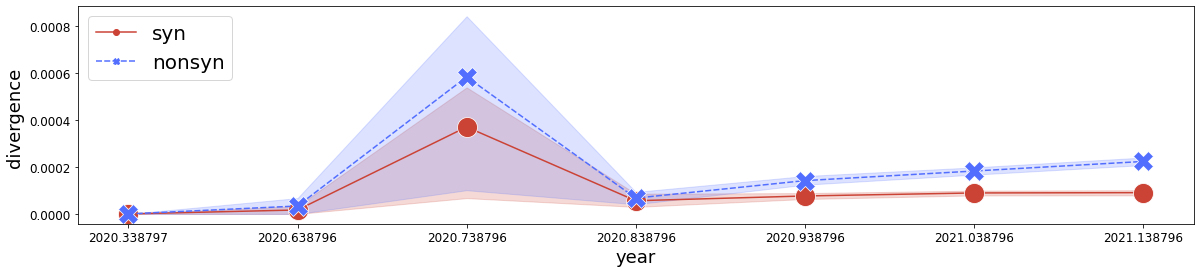

In [24]:
color_map = {'syn': '#CB4335', 'nonsyn': '#526EFF'
#          'spike': '#009888', 's1': '#87C735', 's2': '#526EFF', 
#          'membrane': '#FF9A00', 'envelope': '#FFCD00', 'nucleoprotein': '#7F4FC9'
            }

fig, ax = plt.subplots(figsize=(20,4))
ax = sns.lineplot(x='year', y='divergence', hue='substitution', palette= color_map, 
                     style = 'substitution', markers = True, markersize = 20, 
                  data = df_to_plot_all)
# if clade != None:
#     plt.title((str(cov)+' lineage '+str(clade)), fontsize=20)
# else:
#     plt.title(str(cov), fontsize=20)
ax.tick_params(labelsize=12)
plt.xlabel('year', fontsize=18)
plt.ylabel('divergence ', fontsize=18)
plt.legend(prop={'size': 20}, loc=2)





## Divergence (Hamming) for Wastewater sequences only

Following the same script used in the section above

In [33]:
!cat resources/june_aug_sep_timepoints_consensus.fasta resources/MN908947_3.fasta > ww_sequences_only/ww_tp_sequences_ref.fasta

In [34]:
# Getting list of sequences from original document

def sequence_extract_fasta(fasta_files):
    fasta_id = []
    fasta_seq = []

    # opening given fasta file using the file path
    with open(fasta_files, 'r') as fasta_file:
        # extracting multiple data in single fasta file using biopython
        for record in SeqIO.parse(fasta_file, 'fasta'):  # (file handle, file format)
        
            # appending extracted fasta data to empty lists variables
            fasta_seq.append(record.seq)
            fasta_id.append(record.id)
    return fasta_id#, fatsa_seq


sequences = sequence_extract_fasta('ww_sequences_only/ww_tp_sequences_ref.fasta')

#list of fasta ID's from the filtered file will be saved in the variable "sequences"
sequences

['WSLH-222_2022-09-23',
 'WSLH-223_2022-09-27',
 'WSLH-230_2022-08-16',
 'WSLH-231_2022-06-16',
 'MN908947.3']

In [36]:
ww_meta = pd.DataFrame(sequences, columns=['strain'])


ww_meta['WHO_class'] = ["B.1.234","B.1.234","B.1.234","B.1.234","ref"]
ww_meta['division'] = ['Wisconsin','Wisconsin','Wisconsin','Wisconsin','ref']

ww_dates = pd.DataFrame(['2022-09-23', '2022-09-27',  '2022-08-16', '2022-06-16', '2020-03-14'])
ww_meta['date'] = ww_dates

ww_meta = ww_meta.set_index('strain')
ww_meta.to_csv('ww_sequences_only/ww_tp_sequences_metadata.tsv', sep=',')
ww_dec_dates = ww_meta[['date']]

ww_dec_dates.to_csv('ww_sequences_only/name_date_list_ww.tsv', sep=',')

ww_meta

,WHO_class,division,date
strain,,,
WSLH-222_2022-09-23,B.1.234,Wisconsin,2022-09-23
WSLH-223_2022-09-27,B.1.234,Wisconsin,2022-09-27
WSLH-230_2022-08-16,B.1.234,Wisconsin,2022-08-16
WSLH-231_2022-06-16,B.1.234,Wisconsin,2022-06-16
MN908947.3,ref,ref,2020-03-14


In [37]:
%%R

library(lubridate)


data <- read.csv('ww_sequences_only/name_date_list_ww.tsv', sep=',')


data$date <- ymd(data$date)

data$date <- decimal_date(data$date)

data <- data[c('strain', 'date')]
  
write.csv(data, "resources/dates_decimal_ww_only.csv", row.names = TRUE)



In [38]:
%%bash


augur align \
    --sequences resources/june_aug_sep_timepoints_consensus.fasta \
    --reference-sequence resources/MN908947_3.fasta \
    --fill-gaps \
    --output ww_sequences_only/ww_tp_sequences_aligned_2.fasta 

seqkit rmdup -n ww_sequences_only/ww_tp_sequences_aligned_2.fasta > ww_sequences_only/ww_tp_sequences_aligned.fasta

augur tree \
    --alignment ww_sequences_only/ww_tp_sequences_aligned.fasta \
    --output ww_sequences_only/ww_tp_sequences_tree_raw.nwk

augur refine \
    --tree ww_sequences_only/ww_tp_sequences_tree_raw.nwk \
    --alignment ww_sequences_only/ww_tp_sequences_aligned.fasta \
    --metadata ww_sequences_only/ww_tp_sequences_metadata.tsv \
    --output-tree ww_sequences_only/ww_tp_sequences_tree_refined.nwk \
    --output-node-data ww_sequences_only/ww_tp_sequences_branch_lengths.json \
    --timetree \
    --root 'least-squares' \
    --coalescent opt \
    --date-confidence \
    --date-inference marginal 
    
    
augur traits \
    --tree ww_sequences_only/ww_tp_sequences_tree_refined.nwk \
    --metadata ww_sequences_only/ww_tp_sequences_metadata.tsv \
    --output-node-data ww_sequences_only/ww_tp_sequences_traits.json \
    --confidence \
    --columns WHO_class division
    
augur ancestral \
    --tree ww_sequences_only/ww_tp_sequences_tree_refined.nwk \
    --alignment ww_sequences_only/ww_tp_sequences_aligned.fasta \
    --output-node-data ww_sequences_only/ww_tp_sequences_nt_muts.json \
    --inference joint 
    

augur translate \
     --tree ww_sequences_only/ww_tp_sequences_tree_refined.nwk \
     --reference reference_seq_edited.gb \
     --ancestral-sequences ww_sequences_only/ww_tp_sequences_nt_muts.json \
     --output-node-data ww_sequences_only/ww_tp_sequences_aa_muts.json
     

augur clades \
    --tree ww_sequences_only/ww_tp_sequences_tree_refined.nwk \
    --mutations ww_sequences_only/ww_tp_sequences_nt_muts.json ww_sequences_only/ww_tp_sequences_aa_muts.json \
    --clades resources/clades.tsv \
    --reference ww_sequences_only/ww_tp_sequences_aligned.fasta \
    --output-node-data ww_sequences_only/ww_tp_sequences_clades.json 
    

augur export v2 \
    --tree ww_sequences_only/ww_tp_sequences_tree_refined.nwk \
    --metadata ww_sequences_only/ww_tp_sequences_metadata.tsv \
    --node-data ww_sequences_only/ww_tp_sequences_branch_lengths.json ww_sequences_only/ww_tp_sequences_nt_muts.json ww_sequences_only/ww_tp_sequences_aa_muts.json ww_sequences_only/ww_tp_sequences_traits.json \
    --colors resources/color.txt \
    --maintainers LUIS_HADDOCK \
    --lat-longs resources/lat_long.tsv \
    --auspice-config resources/auspice_config.json \
    --output ww_sequences_only/ww_tp_sequences_auspice.json




using mafft to align via:
	mafft --reorder --anysymbol --nomemsave --adjustdirection --thread 1 ww_sequences_only/ww_tp_sequences_aligned_2.fasta.to_align.fasta 1> ww_sequences_only/ww_tp_sequences_aligned_2.fasta 2> ww_sequences_only/ww_tp_sequences_aligned_2.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436

15bp insertion at ref position 26544
	GCAACAACTCAGAGT: WSLH-222_2022-09-23, WSLH-230_2022-08-16, WSLH-231_2022-06-16, WSLH-223_2022-09-27
Trimmed gaps in MN908947.3 from the alignment


[INFO] 0 duplicated records removed


Building a tree via:
	iqtree2 -nt 1 -s ww_sequences_only/ww_tp_sequences_aligned-delim.fasta -m GTR -ninit 2 -n 2 -me 0.05 > ww_sequences_only/ww_tp_sequences_aligned-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300


Building original tree took 0.5200150012969971 seconds
augur refine is using TreeTime version 0.9.3

0.60	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

0.66	TreeTime.reroot: with method or node: least-squares

0.66	TreeTime.reroot: rerooting will account for covariance and shared ancestry.

0.70	###TreeTime.r






















		This will cause transmissions & demes involving this location not to be displayed in Auspice


Validating schema of 'ww_sequences_only/ww_tp_sequences_nt_muts.json'...
Validating schema of 'ww_sequences_only/ww_tp_sequences_aa_muts.json'...
Validating config file resources/auspice_config.json against the JSON schema
Validating schema of 'resources/auspice_config.json'...
Validating produced JSON
Validating schema of 'ww_sequences_only/ww_tp_sequences_auspice.json'...
Validating that the JSON is internally consistent...
Validation of 'ww_sequences_only/ww_tp_sequences_auspice.json' succeeded, but there were warnings you may want to resolve.



In [12]:
import pandas as pd
dates= pd.read_csv('resources/dates_decimal_ww_only.csv')
dates = dates[['strain', 'date']]
dates = dates.set_index('strain')
dates.to_csv('resources/dates_decimal_ww_only.csv', sep=',')

In [13]:
%%bash

treetime clock \
--tree ww_sequences_only/ww_tp_sequences_tree_raw.nwk \
--aln ww_sequences_only/ww_tp_sequences_aligned.fasta \
--dates resources/dates_decimal_ww_only.csv \
--name-column strain \
--date-column date \
--clock-filter 3 \
--reroot 'oldest' \
--outdir ww_sequences_only/ww_rtt \
--covariation 


0.00	-TreeAnc: set-up

Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.44	TreeTime.reroot: with method or node: oldest

0.45	TreeTime.reroot: with method or node: oldest

0.45	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

0.49	TreeTime.reroot: with method or node: least-squares

0.49	TreeTime.reroot: rerooting will account for covariance and shared ancestry.

0.51	###TreeTime.run: INITIAL ROUND

0.74	TreeTime.reroot: with method or node: oldest

 Root-Tip-Regression:
 --rate:	1.037e-03 +/- 1.31e-04 (one std-dev)
 --chi^2:	13.96
 --r^2:  	0.95

The R^2 value indicates the fracti

In [25]:
def separate_clades(cov, gene):
#     if cov == 'hku1':
#         clade_file = '../'+str(cov)+'/results/clades_full.json'

    if path.exists(str(cov)+'/'+str(gene)+'.json'):
        clade_file = str(cov)+'/'+str(gene)+'.json'

    #         if gene =='spike' or gene == 's1' or gene == 's2':
    #             clade_file = '../'+str(cov)+'/results/clades_spike.json'
    else:
        clade_file = str(cov)+'/'+str(gene)

    clade_lists = []
    with open(clade_file, "r") as clade_handle:
        clades = json.load(clade_handle)
        for node, v in clades['nodes'].items():
            if 'NODE' not in node:
                clade_lists.append({'clade':v['clade_membership'],
                                   'strain':node})

    clade_df = pd.DataFrame(clade_lists)
    return clade_df


In [26]:
def divergence_by_clade(cov, gene, window, clade, min_seqs, year_max=None, year_min=None):
        #Find fraction of sites that differ from root and average among all viruses at each time point
    #input_file_root = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = 'ww_sequences_only/ww_tp_sequences_aligned.fasta'
    metafile = 'ww_sequences_only/ww_tp_sequences_metadata.tsv'
    decimal_dates = 'resources/dates_decimal_ww_only.csv'


    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = ',')
    meta_d = pd.read_csv(decimal_dates, sep = ',')
    meta = meta.rename(columns={"date": "d_date"})
    meta = meta_d.merge(meta, on='strain')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].astype('str').str[:11].astype('float')
    full_date = meta[['date','strain']]

    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)


    date_range = meta['year'].max() - meta['year'].min()


    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)


    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()



    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max()+window:
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 0.01
            date_window_start += 0.01


    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    total_subs_fractions = []
    syn_fractions = []
    nonsyn_fractions = []
    total_subs_fractions_avg = []
    syn_fractions_avg = []
    nonsyn_fractions_avg = []

    #track all mutations that occur in tree
    nt_muts = []

    #strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    root_seq = ''
    root_aa_seq = ''


    for years, subset_viruses in virus_time_subset.items():
        #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))


            #make consensus sequence at first time point
            if first_window == True:
                first_window_strains+=subset_viruses
                with open(input_file_alignment, "r") as aligned_handle:
                    for virus in SeqIO.parse(aligned_handle, "fasta"):
                        if virus.id in first_window_strains:
                            first_window_sequences.append(virus)

                first_window_alignment = MultipleSeqAlignment(first_window_sequences)
                root_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
                root_aa_seq = root_seq.translate()

                first_window = False

            fraction_subs = []
            fraction_syn = []
            fraction_nonsyn = []

            #calculate divergence at all subsequent time points
            with open(input_file_alignment, "r") as aligned_handle:

                for virus in SeqIO.parse(aligned_handle, "fasta"):  

                        #Only viruses in time window

                    if virus.id in subset_viruses:    

                        #check
                        if len(virus.seq) != len(root_seq):
                            print(virus)

                        elif len(virus.seq) == len(root_seq):
                            count_total_unambiguous = 0
                            count_subs = 0
                            count_syn_subs = 0
                            count_nonsyn_subs = 0
                            for pos in range(len(root_seq)):
                                root_nt = str(root_seq[pos])
                                virus_nt = str(virus.seq[pos])    

                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    if root_nt != 'N':
                                        count_total_unambiguous+=1
                                        if virus_nt != root_nt:
                                            count_subs+=1
                                            #determine syn or nonsyn
                                            codon = math.floor(pos/3)


                                            codon_pos = pos-(codon*3)

                                            if codon_pos == 0:
                                                codon_nt = virus.seq[pos:(pos+3)]
                                            elif codon_pos == 1:
                                                codon_nt = virus.seq[(pos-1):(pos+2)]

                                            elif codon_pos == 2:
                                                codon_nt = virus.seq[(pos-2):(pos+1)]


                                            codon_aa = codon_nt.translate()
                                            root_aa = root_aa_seq[codon]
                                            #skip ambiguous
                                            if root_aa != 'X':
                                                if codon_aa != root_aa:
                                                    count_nonsyn_subs+=1
                                                    nt_mut = str(root_nt)+str(pos)+str(virus_nt)+'nonsyn'
                                                elif codon_aa == root_aa:
                                                    count_syn_subs+=1
                                                    nt_mut = str(root_nt)+str(pos)+str(virus_nt)+'syn'
                                                if nt_mut not in nt_muts:
                                                    nt_muts.append(nt_mut)
                            fraction_sub_virus = count_subs/count_total_unambiguous
                            fraction_subs.append(fraction_sub_virus)
                            fraction_syn_virus = count_syn_subs/count_total_unambiguous
                            fraction_syn.append(fraction_syn_virus)
                            fraction_nonsyn_virus = count_nonsyn_subs/count_total_unambiguous
                            fraction_nonsyn.append(fraction_nonsyn_virus)            

            fraction_subs_window = sum(fraction_subs)/len(fraction_subs)
            fraction_syn_window = sum(fraction_syn)/len(fraction_syn)
            fraction_nonsyn_window = sum(fraction_nonsyn)/len(fraction_nonsyn)

            total_subs_fractions.append(fraction_subs)
            syn_fractions.append(fraction_syn)
            nonsyn_fractions.append(fraction_nonsyn)

            total_subs_fractions_avg.append(fraction_subs_window)
            syn_fractions_avg.append(fraction_syn_window)
            nonsyn_fractions_avg.append(fraction_nonsyn_window)

    return year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg, nt_muts, full_date


In [27]:
cov = 'ww_sequences_only'
gene = 'ww_tp_sequences_clades.json'
genes = gene
window = 0.01
clade = 'unassigned'
min_seqs = 1
year_max=None
year_min=None
filename=None
ref = 'resources/MN908947_3.fasta'
meta = 'ww_sequences_only/ww_tp_sequences_metadata.tsv'  


df_to_plot_spike = []
#for gene in genes:
year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg, nt_muts, full_date = divergence_by_clade(cov, gene, window, clade, min_seqs, year_max, year_min)


for window_index in range(len(year_windows)):
    for virus_syn in syn_fractions[window_index]:
        df_to_plot_spike.append({'year': year_windows[window_index][0:11], 
                             'gene': gene, 'substitution': 'syn', 
                             'divergence': virus_syn})
    for virus_nonsyn in nonsyn_fractions[window_index]:
        df_to_plot_spike.append({'year': year_windows[window_index][0:11], 
             'gene': gene, 'substitution': 'nonsyn', 
             'divergence': virus_nonsyn})


df_to_plot_ww = pd.DataFrame(df_to_plot_spike)
#df_to_plot_spike['year'] = df_to_plot_spike['year'].astype('float')

df_to_plot_ww


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


,year,gene,substitution,divergence
0,2020.199453,ww_tp_sequences_clades.json,syn,0.000000
1,2020.199453,ww_tp_sequences_clades.json,nonsyn,0.000000
2,2022.449452,ww_tp_sequences_clades.json,syn,0.001010
3,2022.449452,ww_tp_sequences_clades.json,nonsyn,0.002298
4,2022.619452,ww_tp_sequences_clades.json,syn,0.000674
5,2022.619452,ww_tp_sequences_clades.json,nonsyn,0.001819
6,2022.719452,ww_tp_sequences_clades.json,syn,0.000807
7,2022.719452,ww_tp_sequences_clades.json,nonsyn,0.002353
8,2022.729452,ww_tp_sequences_clades.json,syn,0.000807
9,2022.729452,ww_tp_sequences_clades.json,nonsyn,0.002152


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


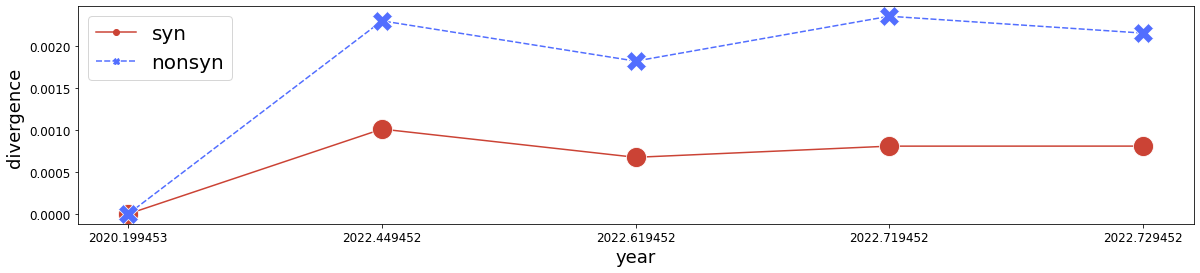

In [28]:
color_map = {'syn': '#CB4335', 'nonsyn': '#526EFF'
#          'spike': '#009888', 's1': '#87C735', 's2': '#526EFF', 
#          'membrane': '#FF9A00', 'envelope': '#FFCD00', 'nucleoprotein': '#7F4FC9'
            }

fig, ax = plt.subplots(figsize=(20,4))
ax = sns.lineplot(x='year', y='divergence', hue='substitution', palette= color_map, 
                     style = 'substitution', markers = True, markersize = 20, 
                  data = df_to_plot_ww)
# if clade != None:
#     plt.title((str(cov)+' lineage '+str(clade)), fontsize=20)
# else:
#     plt.title(str(cov), fontsize=20)
ax.tick_params(labelsize=12)
plt.xlabel('year', fontsize=18)
plt.ylabel('divergence ', fontsize=18)
plt.legend(prop={'size': 20}, loc=2)





In [29]:
df_to_plot_ww['type'] = 'ww'
df_to_plot_ww['sample'] = df_to_plot_ww['type'] + '_' + df_to_plot_ww['substitution']
df_to_plot_ww = df_to_plot_ww[df_to_plot_ww['year']>'2021']

In [30]:
df_to_plot_all['type'] = 'all'
df_to_plot_all['sample'] = df_to_plot_all['type'] + '_' + df_to_plot_all['substitution']

In [31]:
df_to_plot_all

,year,gene,substitution,divergence,type,sample
0,2020.338797,b1234_sequences_clades,syn,0.000000,all,all_syn
1,2020.338797,b1234_sequences_clades,syn,0.000000,all,all_syn
2,2020.338797,b1234_sequences_clades,nonsyn,0.000000,all,all_nonsyn
3,2020.338797,b1234_sequences_clades,nonsyn,0.000000,all,all_nonsyn
4,2020.638796,b1234_sequences_clades,syn,0.000034,all,all_syn
...,...,...,...,...,...,...
471,2021.138796,b1234_sequences_clades,nonsyn,0.000269,all,all_nonsyn
472,2021.138796,b1234_sequences_clades,nonsyn,0.000303,all,all_nonsyn
473,2021.138796,b1234_sequences_clades,nonsyn,0.000438,all,all_nonsyn
474,2021.138796,b1234_sequences_clades,nonsyn,0.000168,all,all_nonsyn


In [32]:
df_to_plot_append = df_to_plot_all.append(df_to_plot_ww)
df_to_plot_append

/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_69300/4146905209.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_plot_append = df_to_plot_all.append(df_to_plot_ww)


,year,gene,substitution,divergence,type,sample
0,2020.338797,b1234_sequences_clades,syn,0.000000,all,all_syn
1,2020.338797,b1234_sequences_clades,syn,0.000000,all,all_syn
2,2020.338797,b1234_sequences_clades,nonsyn,0.000000,all,all_nonsyn
3,2020.338797,b1234_sequences_clades,nonsyn,0.000000,all,all_nonsyn
4,2020.638796,b1234_sequences_clades,syn,0.000034,all,all_syn
...,...,...,...,...,...,...
5,2022.619452,ww_tp_sequences_clades.json,nonsyn,0.001819,ww,ww_nonsyn
6,2022.719452,ww_tp_sequences_clades.json,syn,0.000807,ww,ww_syn
7,2022.719452,ww_tp_sequences_clades.json,nonsyn,0.002353,ww,ww_nonsyn
8,2022.729452,ww_tp_sequences_clades.json,syn,0.000807,ww,ww_syn


In [33]:
test = df_to_plot_append.copy()
test = test.set_index('year')
test.to_csv('resources/divergence_values_ncbi.csv', sep=',')


In [34]:
%%R

#changing from decimal dates to yyyy-mm-dd format
library(lubridate)


data <- read.csv('resources/divergence_values_ncbi.csv', sep=',')


data$year <- date_decimal(data$year)

  
write.csv(data, "resources/divergence_values_ymd_ncbi.csv", row.names = TRUE)


In [35]:
df = pd.read_csv('resources/divergence_values_ymd_ncbi.csv')
df['year'] = pd.to_datetime(df['year'])
df['year'] = df['year'].dt.date

df = df[['year', 'gene', 'substitution', 'divergence', 'type',
       'sample']]
df['year'] = pd.to_datetime(df['year']) - pd.to_timedelta(7, unit='d')
#df[(df['year']>'2020-08')&(df['year']<'2020-10-15')&(df['substitution']=='nonsyn')]

df[(df['year']>'2021-01-01')&(df['year']<'2021-02-01')]

,year,gene,substitution,divergence,type,sample
136,2021-01-08,b1234_sequences_clades,syn,0.000067,all,all_syn
137,2021-01-08,b1234_sequences_clades,syn,0.000067,all,all_syn
138,2021-01-08,b1234_sequences_clades,syn,0.000135,all,all_syn
139,2021-01-08,b1234_sequences_clades,syn,0.000034,all,all_syn
140,2021-01-08,b1234_sequences_clades,syn,0.000000,all,all_syn
...,...,...,...,...,...,...
297,2021-01-08,b1234_sequences_clades,nonsyn,0.000337,all,all_nonsyn
298,2021-01-08,b1234_sequences_clades,nonsyn,0.000236,all,all_nonsyn
299,2021-01-08,b1234_sequences_clades,nonsyn,0.000202,all,all_nonsyn
300,2021-01-08,b1234_sequences_clades,nonsyn,0.000203,all,all_nonsyn


Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




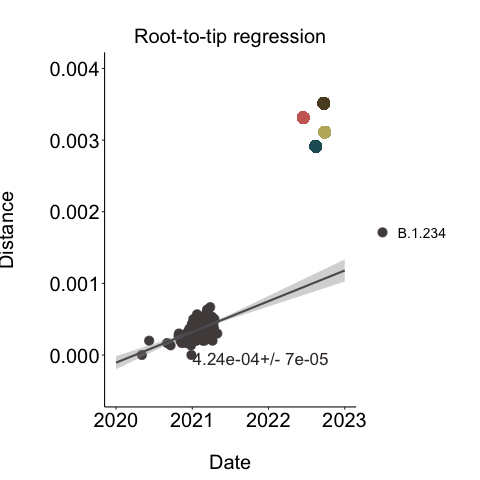

In [36]:
%%R

#Panel A

library(ggplot2)
library(dplyr)

data_rtt <- read.csv('divergence_analysis/root-to-tip_complete.tsv', sep = '\t')
plot <- ggplot(data=data_rtt, aes(x=date, y=distance, 
                                 color=lineage_class)) +
  geom_point(size=4) +
  geom_smooth(data=subset(data_rtt, WHO_class == "B.1.234"),method='lm',formula=y~x, color="#5a5a62", 
              se=TRUE, fullrange=TRUE) +
  #geom_smooth(method='lm',formula=y~x, color="#5a5a62", se=TRUE) +
  scale_color_manual(values=c(B.1.234="#524a4a",Omicron="#594A42"))+
  theme(plot.title = element_text(size=20, hjust=0.5))+
  scale_x_continuous(limits=c(2020,2023)) + #, breaks=seq(2006,2018,2))+
  scale_y_continuous(limits=c(-0.0005,0.004)) +
  geom_point(aes(x=2022.454795, y=0.003314), colour="#CD6A62", size=5) + #june timepoint computed and added manually
  geom_point(aes(x=2022.621918, y=0.002912), colour="#225C64", size=5) + #august timepoint computed and added manually
  geom_point(aes(x=2022.726027, y=0.003514), colour="#5a4a29", size=5) + #September 1 timepoint computed and added manually
  geom_point(aes(x=2022.736986, y=0.003112), colour="#bdb46a", size=5) + #September 2 timepoint computed and added manually

  theme(panel.grid.major=element_line(colour=NA,size=NA))+
  theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
  theme(strip.background = element_rect(colour=NA, fill=NA))+
  labs(title="Root-to-tip regression", y="Distance", x="Date") +
  theme(axis.line.x=element_line(colour="black"))+
  theme(axis.line.y=element_line(colour="black"))+
  theme(axis.title.y=element_text(size=20, vjust=8))+
  theme(axis.title.x=element_text(size=20, vjust=-4))+
  theme(axis.text=element_text(size=20, colour="black"))+
  theme(legend.title=element_blank(),)+
  theme(panel.spacing=unit(1, "lines"))+
  theme(plot.margin=unit(c(1,1,1,1),"cm"))+
  theme(legend.key.size=unit(0.7, "cm"))+
  theme(legend.text = element_text(size=14))+
  theme(panel.background=element_rect(fill=NA))+
  theme(legend.key=element_rect(fill=NA)) +
  #annotate("text",x=2021.6,y=0.0025,label=("5.27e-04+/- 4e-05"), size=7, color='#594A42') + #all Omicron and B.1.234
  annotate("text",x=2021.9,y=-0.00005,label=("4.24e-04+/- 7e-05"), size=6, color='#393131') #B.1.234 only


ggsave('figures/rtt_regression_aligned_to_b1234_ncbi.pdf', dpi=300, width = 8, height = 6, units = 'in' ) 

plot

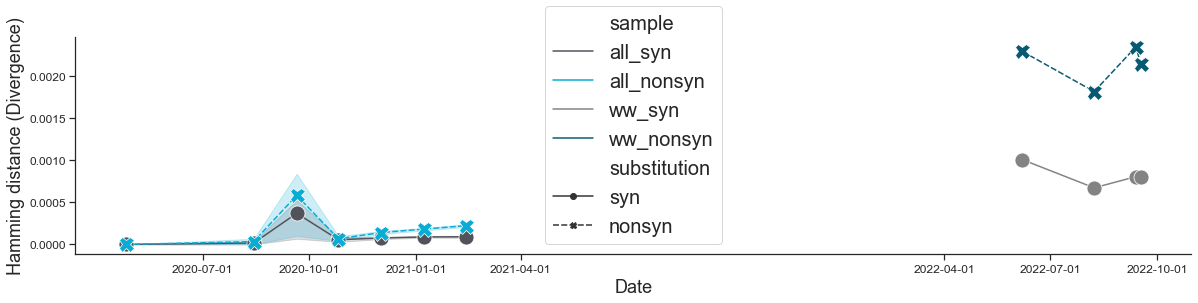

In [37]:
# Panel E

color_map = {'all_syn': '#52525a', 'all_nonsyn': '#08acd5',
          'ww_nonsyn': '#085a73', 'ww_syn': '#838383', 
          'syn': '#FF9A00', 'nonsyn': '#FFCD00', 'nucleoprotein': '#7F4FC9'
            }
ticks=['2020-07', '2020-10', '2021-01', '2021-04', '2022-04', '2022-07', '2022-10']
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize=(20,4))
ax = sns.lineplot(x='year', y='divergence', hue='sample', palette= color_map, 
                     style = 'substitution', 
                  markers = True, markersize = 15, 
                  data = df)
# if clade != None:
#     plt.title((str(cov)+' lineage '+str(clade)), fontsize=20)
# else:
#     plt.title(str(cov), fontsize=20)
ax.tick_params(labelsize=12)
ax.set_xticks(ticks)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Hamming distance (Divergence)', fontsize=18)
plt.legend(prop={'size': 20}, loc='best')


plt.savefig('figures/haming_all_ncbi.pdf', dpi=300)
